

### <p style="text-align:center"><span style="color:red">Data Science Exercise</span></p>

To outline the objectives of this problem, I propose organizing them as follows:

**Objectives:**

1. **Complete Data:** Investigate the possibility of filling missing data in the "emotion_in_tweet_is_directed_at" column to identify additional products/brands.

2. **Analyze Popular Brands/Products:** Identify the most highly regarded brands or products based on the available data.

3. **Analyze Less Popular Brands/Products:** Identify the less favored brands or products using the provided data.

4. **Segment Tweets:** Explore the potential to categorize tweets based on the terms used in the messages.

5. **Analyze Impactful Terms:** Identify the most recurring terms that significantly influence sentiment detection in tweets.

6. **Implement Sentiment Detection Engine:** Develop a sentiment detection engine for tweets, offering choices among three distinct Machine Learning / Deep Learning models.

7. **Understand Misclassifications:** Optionally, comprehend and explain the reasons for algorithmic misclassifications when tweets are intely categorized.

---

### <p style="text-align:left"><span style="color:green">Importing Required Libraries</span></p>

Below are the essential libraries I will be utilizing to tackle this exercise.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Standard Libraries
import time

# Data Processing Libraries
import pandas as pd
import numpy as np

# Text Processing Libraries
import re  # Regular Expression library
import contractions
import string
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize  # Tokenization
from gensim.parsing.preprocessing import remove_stopwords
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import gensim

# Visualization Libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Machine Learning Libraries
import sklearn
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

### <p style="text-align:left"><span style="color:green">Reading and Displaying the `CSV File`</span></p>

In [2]:
tweets_df = pd.read_csv('../data/tweets dataset.csv', encoding = "ISO-8859-1")
tweets_df.head()

tweet_text  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

In [3]:
tweets_df.shape

(9093, 3)



The dataset comprises 9093 records and encompasses three vital columns:

- **`tweet_text`:** Represents the content of the tweet.
  
- **`emotion_in_tweet_is_directed_at`:** Specifies the brand mentioned in the tweet.
  
- **`is_there_an_emotion_directed_at_a_brand_or_product`:** Indicates the emotion/neutrality expressed in the tweet.

### <p style="text-align:left"><span style="color:green">Exploring the dataset</span></p>

Let us first check whether our data is clean and if there are any missing values.


In [4]:
print("The data columns contain the following missing values: ")
tweets_df.isna().sum()

The data columns contain the following missing values: 


tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

**Data Quality Check:**

We have identified a missing tweet, which will be removed later as it holds no relevance to our analysis. Moreover, the 'emotion_in_tweet_is_directed_at' column contains **5802 missing values out of 9093**, signifying a substantial portion of our dataset. We plan to address these missing values in our analysis, as they could offer valuable insights, enhancing our overall understanding and visualization efforts.

**Exploring Tweet Structure:**

To gain a deeper understanding of the tweet's structure and its relationship with the 'emotion_in_tweet_is_directed_at' column, we will examine a selection of samples in their entirety:


In [5]:
random_df  =  tweets_df.sample(n = 200)
for i in range(len(random_df)):
    print(random_df.iloc[i][0])
    print(random_df.iloc[i][1])
    print('----------')


All your Google belong to us? #sxsw {link}
nan
----------
@mention No iPhone? No worries. Drop into one of our venues and talk to a concierge. We'll take care of you! #SXSW #SXSWi
nan
----------
Google vs Bing on #bettersearch. Bing has a shot at success w/ structured search.  Potentially higher margin CPA model vs #Google. #SXSW
Google
----------
RT @mention How Cool is this! #Apple opening a temporary store for the #iPad2 launch and #SXSW {link} #sxswh
Apple
----------
@mention getting ready listening to the  #SXSW party podcasts {link}
nan
----------
RT @mention Found a road dawg to check out this iPad store #sxsw @mention
nan
----------
This #SXSW I am grateful for: my bicycle, having a back-up Twitter app. Cursing: losing an hour of zzzs, iPhone battery life.
iPhone
----------
RT @mention Bad news update: the pop-up Apple Store is out of iPads! Not sure if they will have more by tomorrow. #SXSW
nan
----------
RT @mention RT @mention Google to Launch Major New Social Network Called

**Observations and Preliminary Hypotheses:**

Upon analyzing the results above, several preliminary hypotheses can be made:

1. The structure of the tweets varies; they may begin with a mention, hashtag, or simple words without a standardized pattern.
2. Identifying brands mentioned in the tweets is challenging, especially when they lack hashtags or mentions. This complicates the task of replacing missing values in the brand column.
3. The tweets often include insignificant words or characters that provide no useful information. These elements will be removed during the analysis process.


**Exploring the Target Column: *is_there_an_emotion_directed_at_a_brand_or_product***

Now, let's delve into our target column, *is_there_an_emotion_directed_at_a_brand_or_product*, and examine the different classes it contains:


In [6]:
tweets_df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

We observe a noticeable class imbalance in the target variable, potentially leading to lower recall rates post-model training. 

>'Bad recall' refers to the model's tendency to predict the class with higher samples. Addressing this imbalance is crucial for accurate predictions and overall model performance.

**Analysis of Emotion Classes in Tweets:**

Upon examination, it appears that there are four distinct classes that rate the emotions expressed in the tweets. However, these classes are not well-balanced, with particular emphasis on the significant imbalance in the "I can't tell" category. There are very few instances of this class compared to the others. Given its limited usefulness for our analysis, we plan to remove this category later in our data processing.


### <p style="text-align:left"><span style="color:green">Cleaning and preprocessing</span></p>

**Renaming the columns in the DataFrame for clarity and consistency**

In [7]:
tweets_df.rename(columns={'tweet_text': 'tweets',
                          'emotion_in_tweet_is_directed_at': 'brands',
                          'is_there_an_emotion_directed_at_a_brand_or_product': 'emotions'}, 
                 inplace=True)


These names are more meaningful and easier to use.

**Removing rows where the 'emotions' column is labeled as "I can't tell" and dropping thre row with missing 'tweets' value for data cleaning**


In [8]:
drop_indexes = tweets_df[(tweets_df['emotions'] == "I can't tell")].index
tweets_df.drop(drop_indexes, inplace = True)
tweets_df.dropna(subset = ['tweets'], inplace=True)

The number of 'I can't tell' instances within the target class is very low; therefore, we are dropping it to mitigate the issue of class imbalance.

**Checking the number of missing values in each column of the 'tweets_df' DataFrame**


In [9]:
tweets_df.isna().sum()

tweets         0
brands      5654
emotions       0
dtype: int64

**Counting the occurrences of each unique value in the 'emotions' column of the 'tweets_df' DataFrame**


In [10]:
tweets_df['emotions'].value_counts()

emotions
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: count, dtype: int64

**Calculating the relative frequencies (normalized counts) of unique values in the 'emotions' column of the 'tweets_df' DataFrame**

In [11]:
tweets_df['emotions'].value_counts(normalize = True)

emotions
No emotion toward brand or product    0.602954
Positive emotion                      0.333259
Negative emotion                      0.063787
Name: proportion, dtype: float64

**Plotting a stacked bar chart to visualize the distribution of emotions in the 'emotions' column of 'tweets_df'**

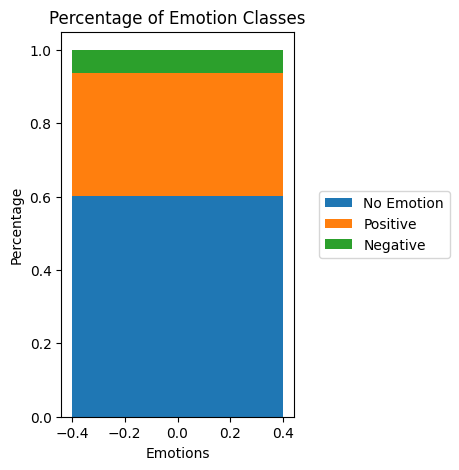

In [12]:
plt.figure(figsize=(3, 5))

# Creating the classes percentages
percentages = tweets_df['emotions'].value_counts(normalize=True)

# Creating a bar plot with stacked bars representing different emotion classes
plt.bar(0, percentages[0], label='No Emotion')
plt.bar(0, percentages[1], bottom=percentages[0], label='Positive')
plt.bar(0, percentages[2], bottom=sum(percentages[:2]), label='Negative')

# Adding legend outside the plot area
plt.legend(bbox_to_anchor=(1.7, 0.5), loc="center right")

# Setting axis labels and plot title
plt.xlabel('Emotions')
plt.ylabel('Percentage')
plt.title('Percentage of Emotion Classes')
plt.show()


> The chart illustrates the proportion of each emotion class, namely `'No Emotion'`, `'Positive'`, and `'Negative'`.

**Emotion Distribution Pie Chart** (A pie plot is more suitable for this visualization in our case)

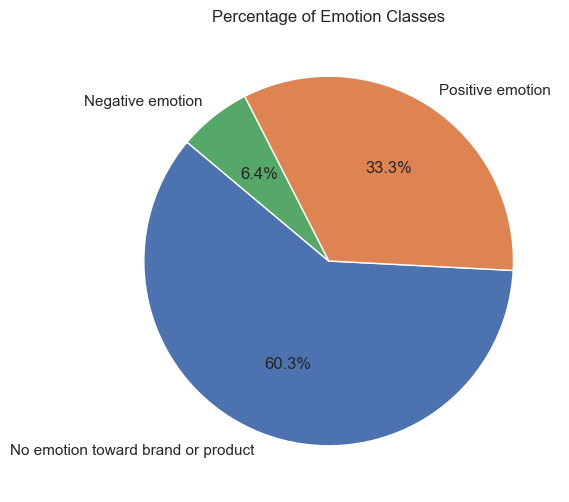

In [13]:
# Calculate the class percentages
percentages = tweets_df['emotions'].value_counts(normalize=True)

# Set the style to use Seaborn's color palette
sns.set(style="whitegrid")

# Create a pie chart (circle plot)
plt.figure(figsize=(8, 6))
plt.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("deep"))

# Set the title
plt.title('Percentage of Emotion Classes')

# Show the plot
plt.show()

**Visualize the distribution of each class in the Target**

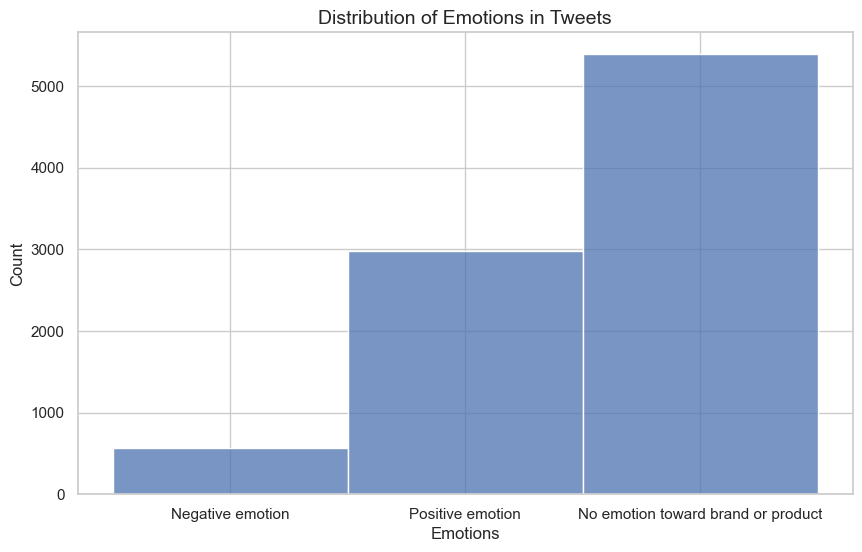

In [14]:
plt.figure(figsize=(10, 6))

# Create the histogram plot with custom parameters
sns.histplot(data=tweets_df, x='emotions')

# Add labels and title for better understanding
plt.xlabel('Emotions', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Emotions in Tweets', fontsize=14)

# Display the plot
plt.show()

We still face class imbalance due to the lower number of instances in the 'Negative Emotion' class, but we will retain it for now.

### <p style="text-align:left"><span style="color:blue">Answering Objective 1: Complete Data</span></p>

Yes, it is possible to complete the "emotion_in_tweet_is_directed_at" column. Here are three approaches to achieve this:

1. **Creating a Word Dictionary:**
   - We can create a dictionary associating words with product/brand categories. By scanning tweets, if a word matches a category in the dictionary, we can assign that category to the "emotion_in_tweet_is_directed_at" column. However, this method can become complex to manage when new categories emerge, requiring constant additions to the dictionary.

2. **Using Pre-trained Named Entity Recognition (NER) Models:**
   - Pre-trained Named Entity Recognition models can be employed to extract entities such as product/brand names from tweet text. These neural network-based models are highly efficient in identifying entities. However, their implementation can be challenging for our use case due to complexity.

3. **Deduction from Another Column (like "tweet_text"):**
   - We can deduce the value of "emotion_in_tweet_is_directed_at" from the "tweet_text" column by examining hashtags present in the tweets. If a hashtag matches a product/brand category, this information can be used to populate the "emotion_in_tweet_is_directed_at" column. However, this method may not be entirely accurate as hashtags do not always precisely correspond to the product/brand category.

Each approach has its pros and cons. The choice of method depends on the required precision and the complexity one is willing to handle during implementation. Despite its complexity, the second method remains the most pr
e


> This time, I will implement the **Creating a Word Dictionary method later** to fill the column.cise option.

**Counting the occurrences of each unique value in the 'brands' column of the 'tweets_df' DataFrame**


In [15]:
tweets_df['brands'].value_counts()

brands
iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: count, dtype: int64

**Grouping the 'tweets_df' DataFrame by 'emotions' and 'brands' columns and counting the occurrences of each brand within each emotion class**

In [16]:
grouped_by_emotions = tweets_df.groupby(['emotions'])['brands'].value_counts()
grouped_by_emotions

emotions                            brands                         
Negative emotion                    iPad                               125
                                    iPhone                             103
                                    Apple                               95
                                    Google                              68
                                    iPad or iPhone App                  63
                                    Other Google product or service     47
                                    Android                              8
                                    Android App                          8
                                    Other Apple product or service       2
No emotion toward brand or product  iPad                                24
                                    Apple                               21
                                    Google                              15
                                

**Brands Associated with Positive Emotion**

<Axes: ylabel='brands'>

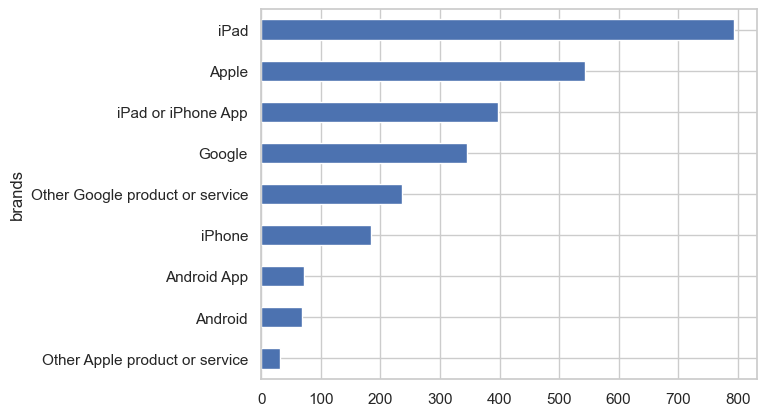

In [17]:
grouped_by_emotions['Positive emotion'].sort_values().plot(kind='barh', stacked=True)

**Brands Associated with Negative Emotion**

<Axes: ylabel='brands'>

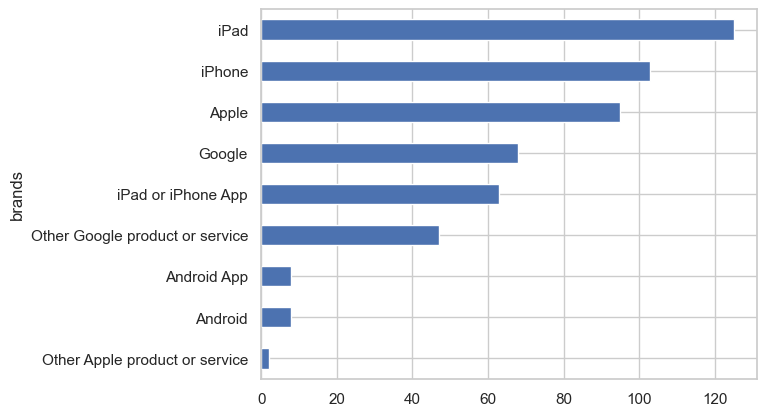

In [18]:
grouped_by_emotions['Negative emotion'].sort_values().plot(kind='barh', stacked=True)

**Emotion Distribution Across Brands**

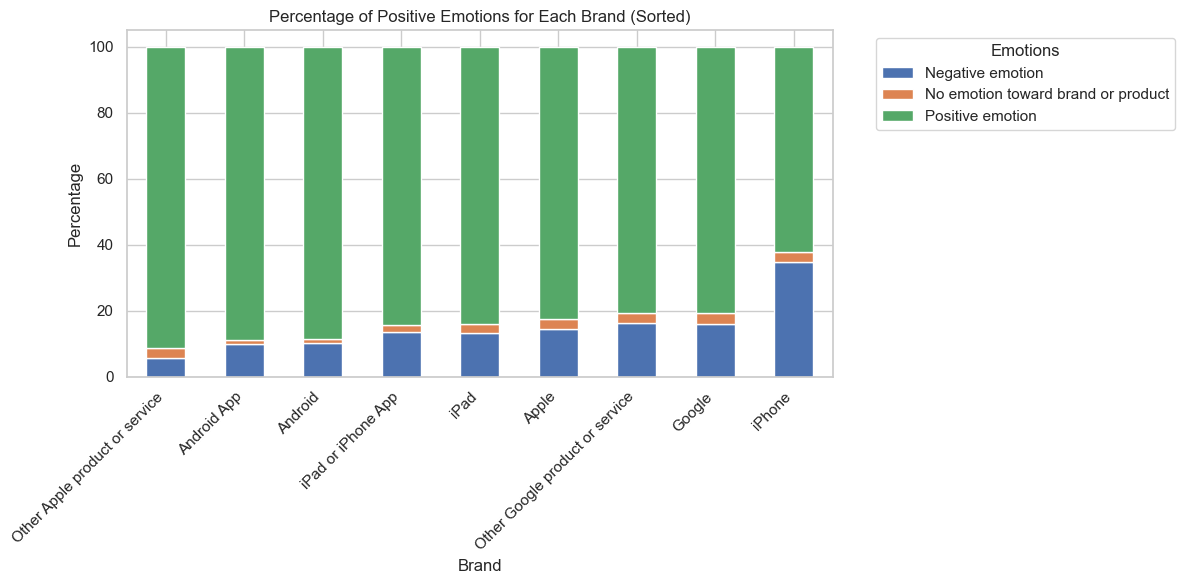

In [19]:
# Grouping the data by 'brands' and 'emotions' and calculating the count of each combination
grouped = tweets_df.groupby(['brands', 'emotions']).size().unstack()

# Calculating the total count of each brand
total_counts = grouped.sum(axis=1)

# Calculating percentages for each brand's positive emotion
percentage_data = grouped.div(total_counts, axis=0) * 100

# Sorting the DataFrame by the percentage of positive emotion in descending order
sorted_percentage_data = percentage_data.sort_values(by='Positive emotion', ascending=False)

# Creating a stacked bar plot to visualize the percentage of positive emotions for each brand (sorted)
ax = sorted_percentage_data.plot(kind='bar', stacked=True, figsize=(12, 6))
ax.set_xlabel('Brand')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of Positive Emotions for Each Brand (Sorted)')
plt.xticks(rotation=45, ha='right')  # Rotating x-axis labels for better readability

# Adding a legend
plt.legend(title='Emotions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


### <p style="text-align:left"><span style="color:blue">Answering Objectives 2 and 3: Analyze Popular and Less Popular Brands/Products</span></p>

Based on the three graphs I have plotted, we can address both objectives in two different ways, depending on the perspective:

1. **Considering Frequency of Mentions:**
   - If we are seeking products with the highest number of tweets expressing positive or negative sentiments, the iPad stands out as the most frequently mentioned brand for both positive and negative sentiments. However, this approach has limitations. The term 'iPad' appears most frequently in our tweets, influencing sentiment counts significantly. Therefore, it dominates the rankings, but this does not necessarily reflect genuine popularity or negativity.

2. **Comparing Percentage of Positive and Negative Sentiments:**
   - A more accurate approach is to compare the percentage of positive and negative tweets for each category. This comparison is relative to the total number of tweets for each brand, making it unbiased by the overall number of elements. According to this analysis, the iPhone has the highest percentage of negative tweets, while 'Other Apple product or service' has the highest percentage of positive twe bellowts. This graph provides valuable insights into how people engage with different brands in their tweets, allowing a more nuanced understanding of sentiment patterns.

By adopting the second approach, we gain a deeper understanding of how people interact with various brands in their tweets, allowing us to distinguish genuine sentiment patterns from the influence of frequently mentioned terms like 'iPad'.

In [20]:
tweets_df.head(3)

tweets              brands  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   

           emotions  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion

**Calculating Average Word Count for Each Emotion Category**

In [21]:
# Calculate the word count for each tweet and create a new column 'word_count' in the DataFrame
dataframe = tweets_df.copy(deep=True)
dataframe['word_count'] = dataframe['tweets'].apply(lambda x: len(str(x).split()))

# Initialize an empty dictionary to store emotions and their corresponding average word count
dict_emotions_wordcount = {}

# Extract unique emotion categories from the DataFrame
emotions_names = list(dataframe.emotions.unique())

# Calculate the mean word count for each emotion category and store it in the dictionary
for emotion in emotions_names:
    mean_word_count = dataframe[dataframe['emotions'] == emotion]['word_count'].mean()
    dict_emotions_wordcount[emotion] = mean_word_count

# Print the dictionary containing emotions and their corresponding average word count
for key, value in dict_emotions_wordcount.items():
    print(key, ' : ', value)

Negative emotion  :  18.756140350877192
Positive emotion  :  18.180658159838817
No emotion toward brand or product  :  17.43504083147736


**Word Count Analysis Across Different Emotion Categories**

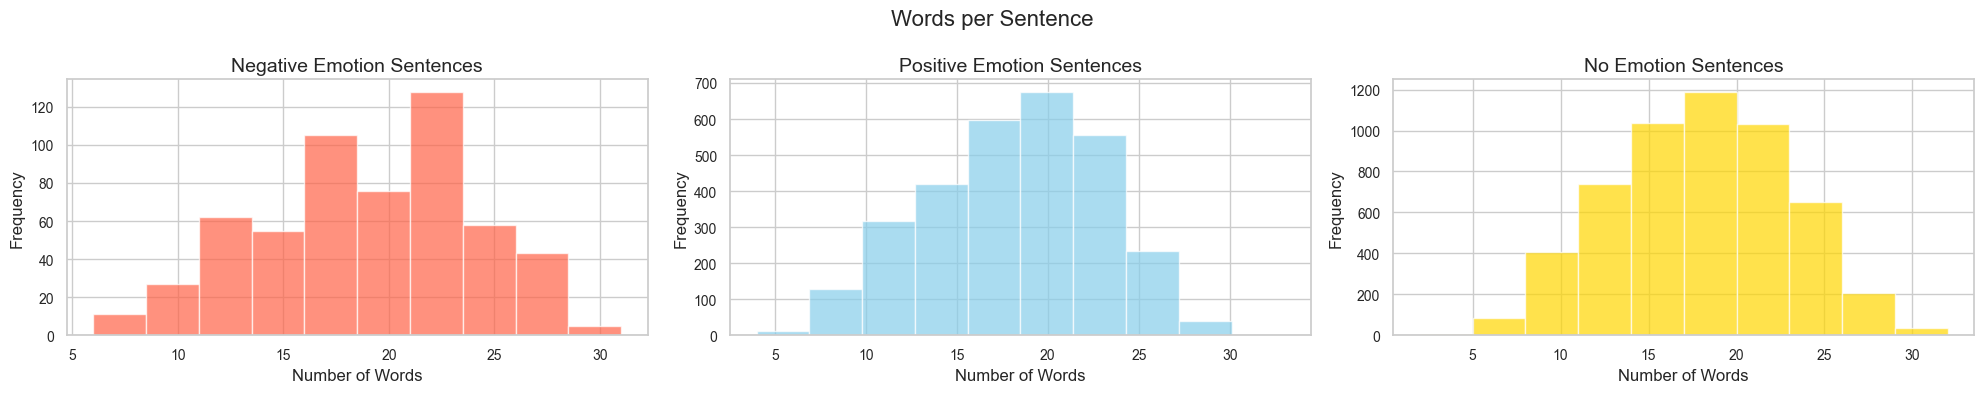

In [22]:
# Define colors for the plots
colors = ['#FF6347', '#87CEEB', '#FFD700']

# PLOTTING WORD-COUNT
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

# Extract sentences for each emotion category
negative_emotion_sentences = dataframe[dataframe['emotions'].str.contains("Negative emotion")]['tweets']
ax1.hist(negative_emotion_sentences.apply(lambda x: len(x.split())), color=colors[0], alpha=0.7)
ax1.set_title('Negative Emotion Sentences', fontsize=14)

positive_emotion_sentences = dataframe[dataframe['emotions'].str.contains("Positive emotion")]['tweets']
ax2.hist(positive_emotion_sentences.apply(lambda x: len(x.split())), color=colors[1], alpha=0.7)
ax2.set_title('Positive Emotion Sentences', fontsize=14)

no_emotions_sentences = dataframe[dataframe['emotions'].str.contains("No emotion")]['tweets']
ax3.hist(no_emotions_sentences.apply(lambda x: len(x.split())), color=colors[2], alpha=0.7)
ax3.set_title('No Emotion Sentences', fontsize=14)

# Set common title for the subplots
fig.suptitle('Words per Sentence', fontsize=16)

# Set common x and y labels for subplots
for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Number of Words', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.tick_params(axis='both', labelsize=10)

# Adjust layout for better spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

The plots above represent the distribution of the word coutns in tweets across each emotion class. Howwever, they don't give much insights since the average number of words is almost the same.   

### **Data Preprocessing:**

Before training the model, the tweets data will undergo extensive preprocessing to enhance the dataset's quality and improve model performance. These steps include:

- **Lowercasing:** Converting the text to lowercase for better generalization and consistency in the dataset.
- **Stop Words Removal:** Eliminating common stop words that do not contribute significant meaning to the text.
- **Emoji Removal:** Removing emojis to focus solely on textual content.
- **Mentions and Hashtags Removal:** Deleting mentions and hashtags to eliminate user-specific information and irrelevant symbols.
- **Numbers Removal:** Eliminating numerical characters that might not hold contextual meaning.
- **Whitespace Removal:** Cleaning up unnecessary spaces for a uniform text structure.
- **Punctuation Cleaning:** Removing punctuation marks to reduce noise in the dataset.
- **Repeating Characters Removal:** Fixing repeated characters in words to standardize the text.
- **URLs/Hyperlinks Removal:** Eliminating URLs and hyperlinks, which usually don't carry significant semantic information.

Further enhancements will be explored in detail during the preprocessing phase.

After these initial steps, additional processes will include:

- **`Stemming`**: Reducing words to their derived stems for linguistic normalization.
- **`Lemmatization`**: Reducing derived words to their root forms (lemmas) for more accurate analysis and interpretation.

In [23]:
# Function to remove mentions (usernames starting with @ and hashtags starting with #)
def remove_mentions(text):
    text = re.sub(r"@\S+|#\S+", "", text)
    return text

# Function to remove punctuations, special characters, and symbols including '&', '%', and '+'
def remove_punctuations(text):
    punct = re.compile("[@$#.;:!?_/,{}\-\\\"()\[\]&%+=]")
    text = punct.sub(" ", text)
    return re.sub(r"\'", " ", text)

# Function to remove small words (1 and 2 characters)
def remove_small_words(text):
    text = re.sub(r"\b\w{1,3}\b", " ", text)
    return text

# Function to remove hyperlinks starting with http or https
def remove_links(text):
    return re.sub(r"http\S+", " ", text)

# Function to remove numbers
def remove_numbers(text):
    return re.sub(r"[0-9]+", " " , text)

# Function to remove placeholder "{link}" with an empty string
def remove_link_placeholder(text):
    text = re.sub(r"\b(?:sxsw|mention)\b", " ", text)
    return re.sub(r'\{link\}', '', text)
    

# Function to remove extra whitespaces and leading/trailing whitespaces
def remove_whitespaces(text):
    text = text.strip()
    return re.sub(r" +", " ", text)

# Main processing function
def process(data):
    # Convert text to lowercase
    data = data.str.lower()
    # Apply functions sequentially to the data
    data = data.apply(remove_link_placeholder)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_mentions)
    # Remove stopwords using NLTK library
    stop_words = set(stopwords.words('english'))
    data = data.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))
    data = data.apply(remove_links)
    data = data.apply(remove_numbers)
    data = data.apply(remove_small_words)
    data = data.apply(remove_whitespaces)
    return data


**Preprocess the Data Using the `process()` Function:**

In [24]:
tweets_df['tweets_processed'] = process(tweets_df['tweets'])
tweets_df.head(4)

tweets              brands  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   

           emotions                                   tweets_processed  
0  Negative emotion  wesley iphone tweeting rise austin dead need u...  
1  Positive emotion  jessedee know fludapp awesome ipad iphone like...  
2  Positive emotion                     swonderlin wait ipad also sale  
3  Negative emotion              hope year festival crashy year iphone

**Tokenizing Tweet Text:** Converting Text to Tokens

In [25]:
tweets_df['tweets_tokenized'] = tweets_df['tweets_processed'].apply(word_tokenize)

# Creating a Word Dictionary

**Brand Identification and Tokenization:** Matching and Tokenizing Tweets' Brands

In [26]:
# Convert 'brands' column to lowercase and drop duplicates
brands = set(tweets_df['brands'].dropna().str.lower().unique())
brands

{'android',
 'android app',
 'apple',
 'google',
 'ipad',
 'ipad or iphone app',
 'iphone',
 'other apple product or service',
 'other google product or service'}

This is the list of brands that we will use to fill up the missing brands.

In [27]:
tweets_df['brands'] = tweets_df['brands'].str.lower()

def fill_brands(tweet_tokenized):
    # Use set intersection to find common elements between brands and tweet_tokenized
    matching_brands = set(tweet_tokenized) & brands
    # Sort the brand names and join them with 'or' as separator
    return " or ".join(sorted(matching_brands))

# Apply fill_brands function to 'tweets_tokenized' and fill NaN values in 'brands' column
tweets_df['brands'] = tweets_df['brands'].fillna(tweets_df['tweets_tokenized'].apply(fill_brands))

In [28]:
tweets_df['brands'].value_counts()

brands
google                             2074
ipad                               1891
apple                              1367
iphone                              981
                                    770
ipad or iphone app                  470
apple or ipad                       438
other google product or service     292
android                             287
android or iphone                   110
android app                          81
ipad or iphone                       59
other apple product or service       35
android or ipad                      20
apple or google                      13
android or google                    13
apple or iphone                      11
android or ipad or iphone             9
google or ipad                        5
android or apple                      5
google or iphone                      2
android or apple or iphone            1
google or ipad or iphone              1
apple or ipad or iphone               1
Name: count, dtype: int64

And these are the newly added/created brands for each category.

**Dropping the old, non-processed tweets**

In [29]:
tweets_df = tweets_df.drop(['tweets'], axis=1)
tweets_df.head(2)

brands          emotions  \
0              iphone  Negative emotion   
1  ipad or iphone app  Positive emotion   

                                    tweets_processed  \
0  wesley iphone tweeting rise austin dead need u...   
1  jessedee know fludapp awesome ipad iphone like...   

                                    tweets_tokenized  
0  [wesley, iphone, tweeting, rise, austin, dead,...  
1  [jessedee, know, fludapp, awesome, ipad, iphon...

# Word Cloud for The Sentiments Column

In [30]:
tweets_df.tweets_tokenized

0       [wesley, iphone, tweeting, rise, austin, dead,...
1       [jessedee, know, fludapp, awesome, ipad, iphon...
2                    [swonderlin, wait, ipad, also, sale]
3            [hope, year, festival, crashy, year, iphone]
4       [sxtxstate, great, stuff, marissa, mayer, goog...
                              ...                        
9088                                   [ipad, everywhere]
9089    [wave, buzz, interrupt, regularly, scheduled, ...
9090    [google, zeiger, physician, never, reported, p...
9091    [verizon, iphone, customers, complained, time,...
9092    [, ¡, , , , , £, , , £, ...
Name: tweets_tokenized, Length: 8936, dtype: object

In [31]:
tweets_df

brands                            emotions  \
0                 iphone                    Negative emotion   
1     ipad or iphone app                    Positive emotion   
2                   ipad                    Positive emotion   
3     ipad or iphone app                    Negative emotion   
4                 google                    Positive emotion   
...                  ...                                 ...   
9088                ipad                    Positive emotion   
9089              google  No emotion toward brand or product   
9090              google  No emotion toward brand or product   
9091              iphone  No emotion toward brand or product   
9092              google  No emotion toward brand or product   

                                       tweets_processed  \
0     wesley iphone tweeting rise austin dead need u...   
1     jessedee know fludapp awesome ipad iphone like...   
2                        swonderlin wait ipad also sale   
3                 hope year festival crashy year iphone   
4     sxtxstate great stuff marissa mayer google rei...   
...                                                 ...   
9088                                    ipad everywhere   
9089  wave buzz interrupt regularly scheduled geek p...   
9090  google zeiger physician never reported potenti...   
9091  verizon iphone customers complained time fell ...   
9092   ¡     £   £ ûârt googl...   

                                       tweets_tokenized  
0     [wesley, iphone, tweeting, rise, austin, dead,...  
1     [jessedee, know, fludapp, awesome, ipad, iphon...  
2                  [swonderlin, wait, ipad, also, sale]  
3          [hope, year, festival, crashy, year, iphone]  
4     [sxtxstate, great, stuff, marissa, mayer, goog...  
...                                                 ...  
9088                                 [ipad, everywhere]  
9089  [wave, buzz, interrupt, regularly, scheduled, ...  
9090  [google, zeiger, physician, never, reported, p...  
9091  [verizon, iphone, customers, complained, time,...  
9092  [, ¡, , , , , £, , , £, ...  

[8936 rows x 4 columns]

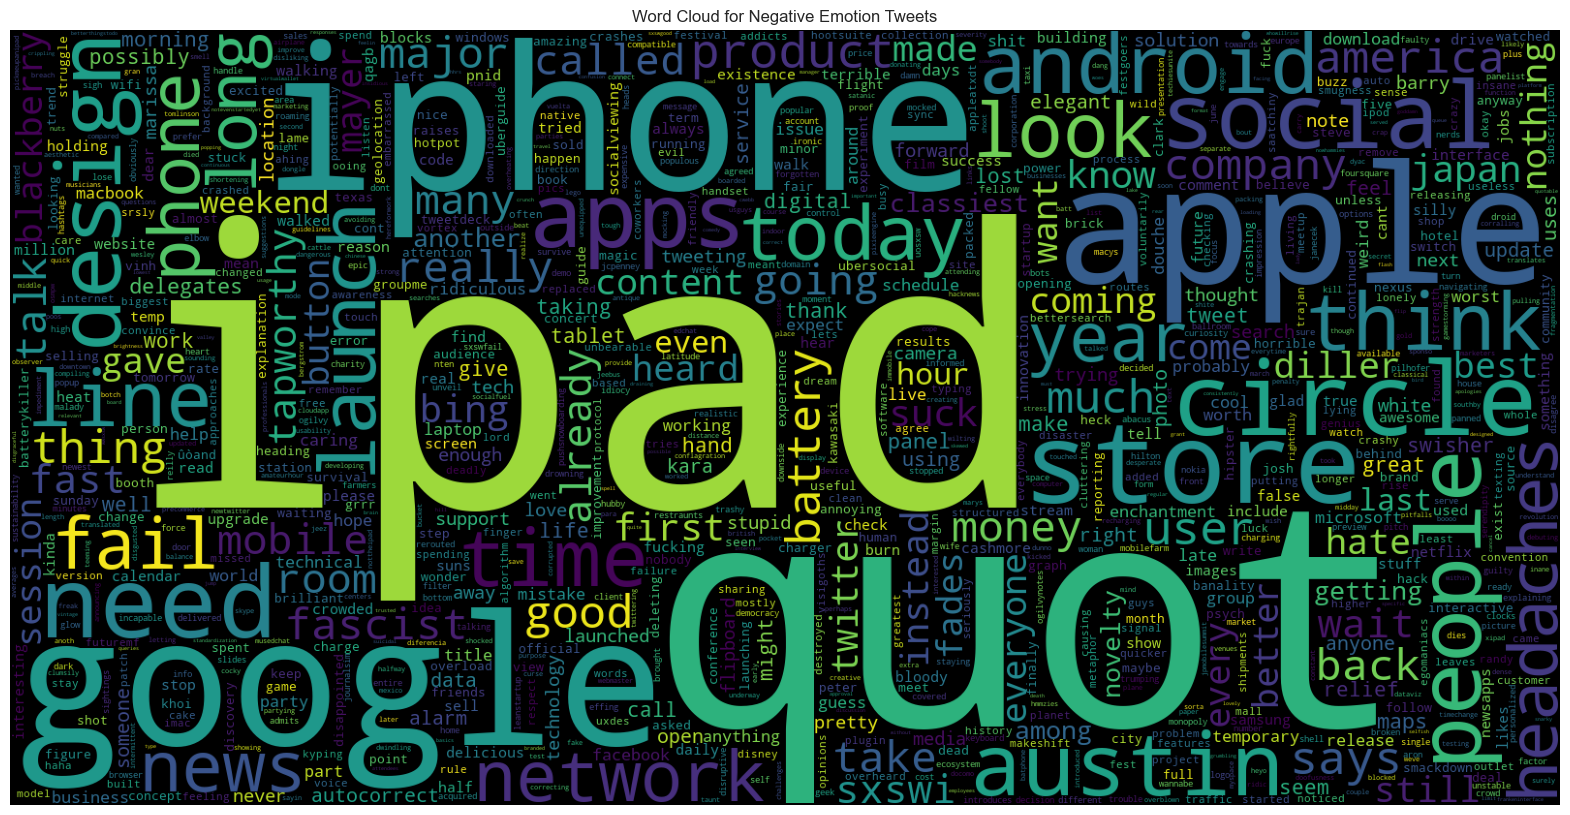

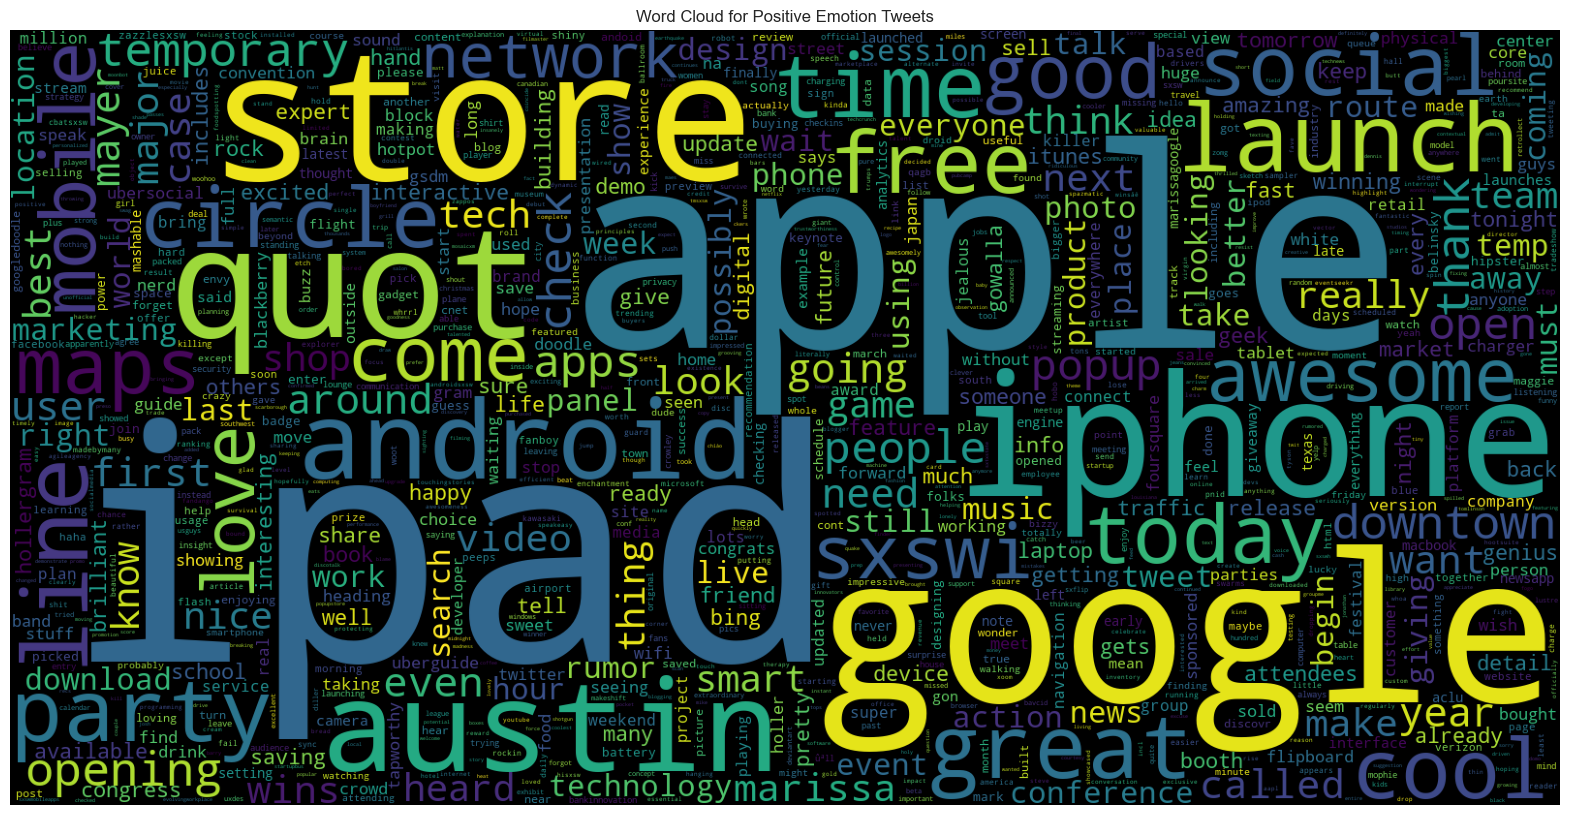

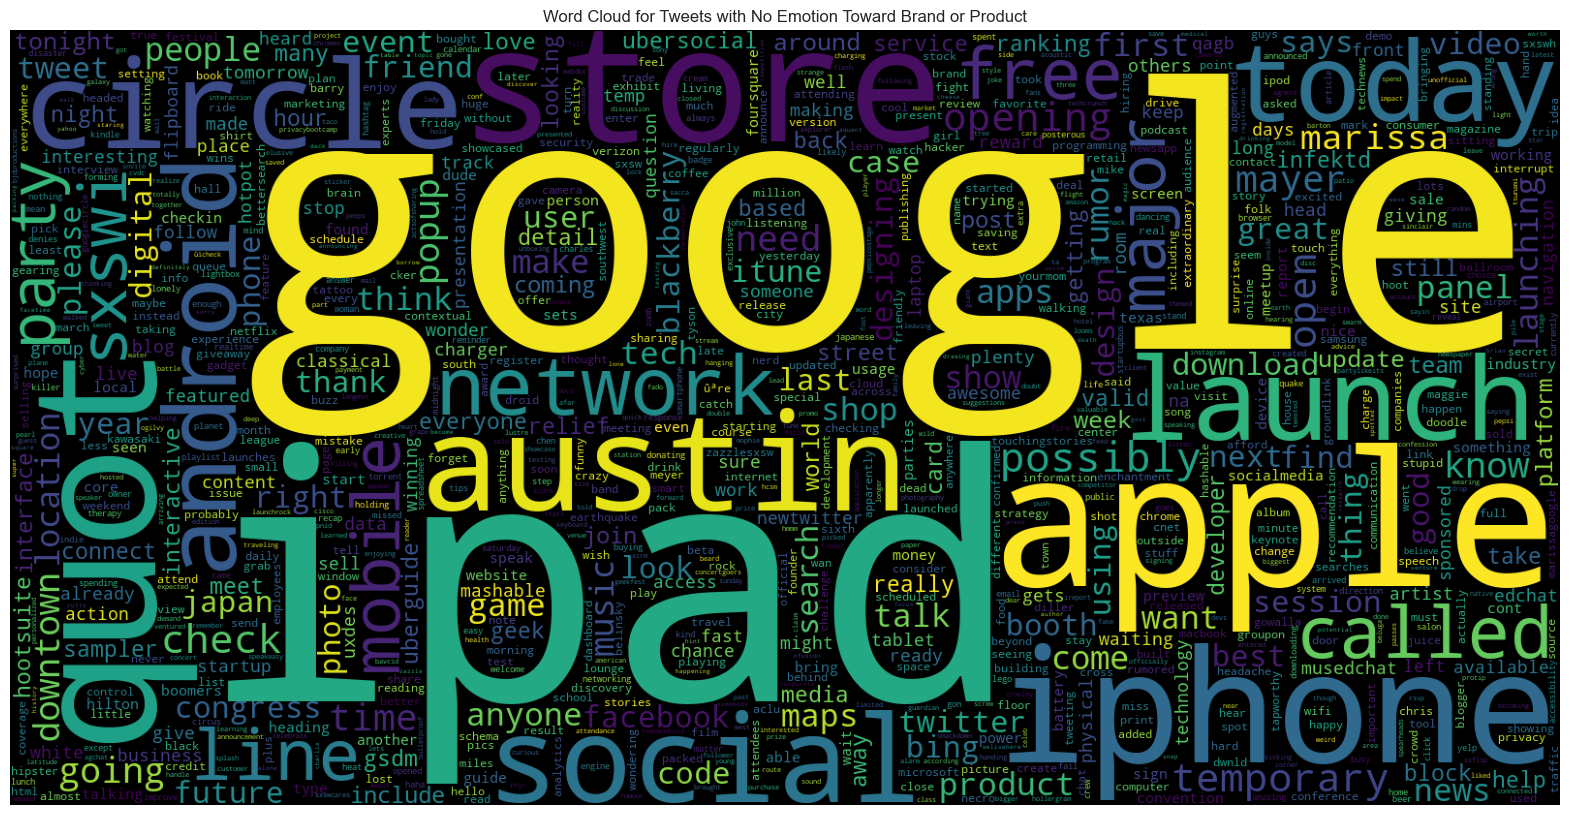

In [32]:
# Function to plot word cloud for a specific emotion
def plot_word_cloud(data, title):
    data_strings = [" ".join(tokens) for tokens in data['tweets_tokenized']]
    plt.figure(figsize=(20, 20))
    wc = WordCloud(max_words=1000, width=1600, height=800, collocations=False).generate(" ".join(data_strings))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(title)
    plt.show()

# Plot word cloud for Negative emotion tweets
data_neg = tweets_df.query("emotions == 'Negative emotion'")
plot_word_cloud(data_neg, "Word Cloud for Negative Emotion Tweets")

# Plot word cloud for Positive emotion tweets
data_pos = tweets_df.query("emotions == 'Positive emotion'")
plot_word_cloud(data_pos, "Word Cloud for Positive Emotion Tweets")

# Plot word cloud for tweets with No emotion toward brand or product
data_no = tweets_df.query("emotions == 'No emotion toward brand or product'")
plot_word_cloud(data_no, "Word Cloud for Tweets with No Emotion Toward Brand or Product")


**Emotion-Specific Word Frequency Analysis**

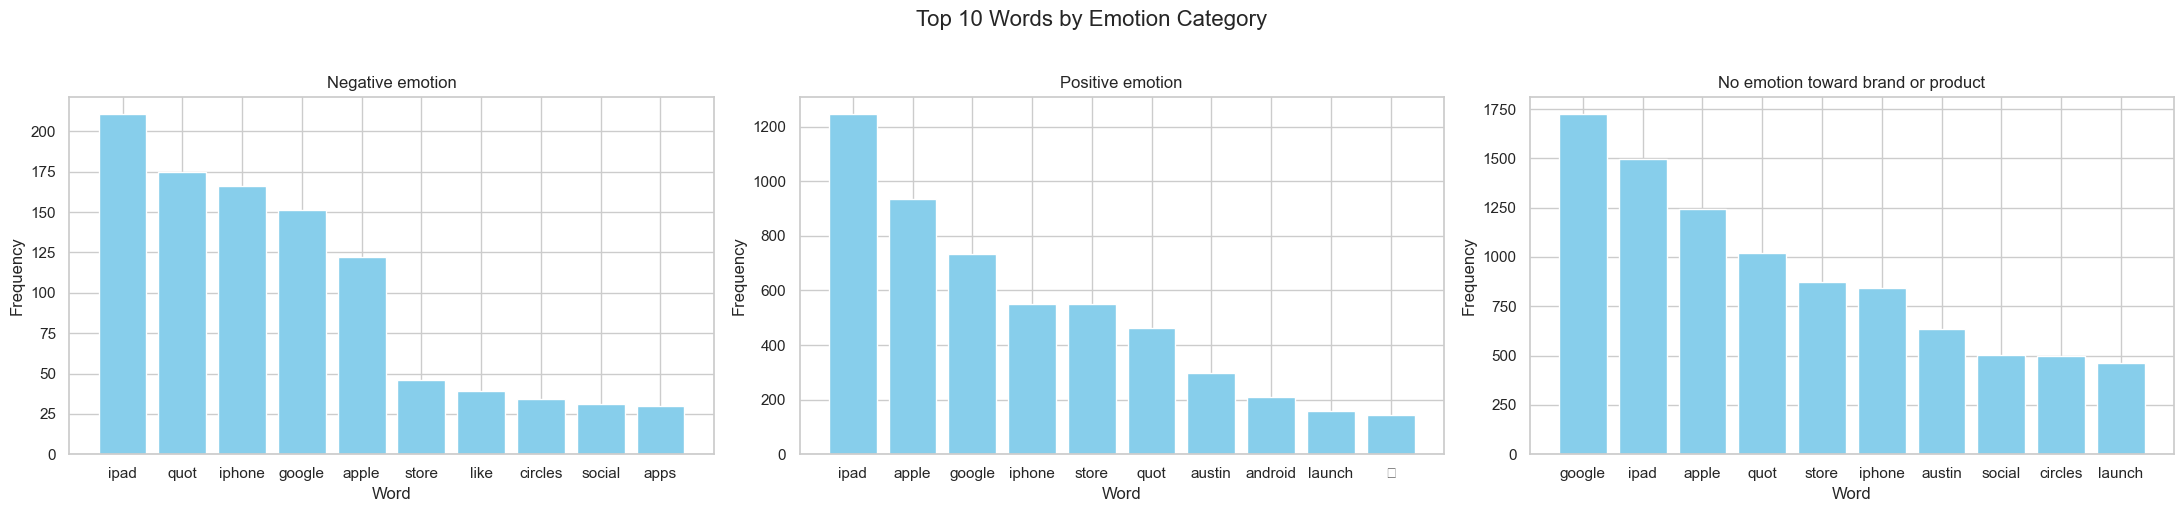

In [33]:
def plot_frequency_by_emotion(dataframe):
    """
    Plots the top 10 most frequent words for each emotion category.
    
    Parameters:
    dataframe (pd.DataFrame): DataFrame containing 'emotions' and 'tweets_tokenized' columns.
    """
    # Set up subplots for each emotion category
    fig, axes = plt.subplots(1, 3, figsize=(22, 5))

    # Iterate over unique emotion categories and plot top 10 tokens for each
    for index, emotion in enumerate(dataframe['emotions'].unique()):
        # Filter dataframe by the current emotion category and tokenize words
        category_tokens = [token for tweet in dataframe[dataframe['emotions'] == emotion]['tweets_tokenized'] for token in tweet]

        # Calculate frequency distribution for tokens in this category
        category_tokens_freq = FreqDist(category_tokens)

        # Get top 10 most common tokens and their counts
        top_10_tokens = [token[0] for token in category_tokens_freq.most_common(10)]
        top_10_counts = [token[1] for token in category_tokens_freq.most_common(10)]

        # Plot bar chart of top 10 tokens and their counts for the current emotion category
        ax = axes[index]
        ax.bar(top_10_tokens, top_10_counts, color='skyblue')
        ax.set_title(emotion)
        ax.set_xlabel('Word')
        ax.set_ylabel('Frequency')

    # Set the main title and display the plot
    plt.suptitle('Top 10 Words by Emotion Category', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame (assuming it's named 'tweets_df')
plot_frequency_by_emotion(tweets_df)


### <p style="text-align:left"><span style="color:blue">Addressing the Challenge of Analyzing Impactful Terms</span></p>

In response to the objective of analyzing impactful terms, our exploration of the last two visualizations, namely the "Top 10 Words by Category" bar charts and the "Word Cloud," reveals the prominent terms associated with each sentiment category. These visualizations provide a direct insight into the words most commonly linked with specific sentiment categories. However, due to the relatively small size of our dataset (comprising only 9,000 lines), certain limitations arise.

#### Challenges and Considerations:

1. **Limited Dataset Size:**
   - The small dataset size poses challenges in drawing definitive conclusions. With fewer instances, the prominence of specific words might be skewed, leading to potential misinterpretation of their actual significance in the broader context.

2. **Data Imbalance:**
   - The absence of balance among sentiment categories could further impact the analysis. Emotions with a higher representation might dominate the identified terms, overshadowing potentially significant words associated with less frequent sentiments.

3. **Repetitive Terms and Their Impact:**
   - Notably, repetitive terms like 'iPad' can distort the analysis. Overly prevalent terms might artificially inflate their importance, leading to a lack of clarity regarding the true diversity of impactful words.

#### Implications for Model Performance:

- **Trustworthiness of Content:**
  - The presence of frequently repeated terms challenges the trustworthiness of the content analysis. It becomes crucial to distinguish between genuinely impactful terms and those influenced by repetition or dataset limitations.

- **Potential Impact on Model Performance:**
  - Misinterpretation of significant terms can adversely affect model performance. Biased input data may lead the model to generalize based on frequent terms, potentially compromising its accuracy in discerninf our sentiment analysis. the dataset.

# Classification - Model Training

In our classification experimentation, we will be utilizing the scikit-learn implementation of the Naive Bayes model, specifically the `MultinomialNB`.

The fundamental assumption behind the Naive Bayes model is that the features (words, in this case) are conditionally independent of each other, given the class.

#### Tf-idf Term Frequency-Inverse Document Frequency
This is the product of the frequency of the term (TF) and its inverse frequency in documents (IDF).
This method is usually used to measure the importance of a term $i$ in a document $j$ relative to the rest of the corpus, from a matrix of occurrences $ words \times documents$. Thus, for a matrix $\mathbf{T}$ of $|V|$ terms and $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

## Model training: SVM classifier with `TfidfVectorizer`

In [34]:
# Quick overview of the dataset we use for training the model
tweets_df.head(3)

brands          emotions  \
0              iphone  Negative emotion   
1  ipad or iphone app  Positive emotion   
2                ipad  Positive emotion   

                                    tweets_processed  \
0  wesley iphone tweeting rise austin dead need u...   
1  jessedee know fludapp awesome ipad iphone like...   
2                     swonderlin wait ipad also sale   

                                    tweets_tokenized  
0  [wesley, iphone, tweeting, rise, austin, dead,...  
1  [jessedee, know, fludapp, awesome, ipad, iphon...  
2               [swonderlin, wait, ipad, also, sale]

**Applying the label encoder to encode the Target column**

In [35]:
# Initialize a LabelEncoder object
label_encoder = LabelEncoder()

# Extract unique values from the 'emotions' column in the tweets_df DataFrame
emotions = tweets_df['emotions'].unique()

# Encode unique emotions and print the mapping between original emotions and their encoded values
emotions_encoded = label_encoder.fit_transform(emotions)
print(dict(zip(emotions, emotions_encoded)))

# Apply label encoding to the 'emotions' column in the tweets_df DataFrame
tweets_df['emotions'] = label_encoder.fit_transform(tweets_df['emotions'])

tweets_df['emotions'].head(3)

{'Negative emotion': 0, 'Positive emotion': 2, 'No emotion toward brand or product': 1}


0    0
1    2
2    2
Name: emotions, dtype: int32

In [36]:
tweets_df['emotions'].value_counts()

emotions
1    5388
2    2978
0     570
Name: count, dtype: int64

**Data Splitting: Preparing Training and Testing Sets**




In [37]:
# Separating the 80% data for training data
X = tweets_df['tweets_processed']
y = tweets_df.emotions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

**Performing classification**

              precision    recall  f1-score   support

           0       0.68      0.18      0.29       126
           1       0.67      0.92      0.78      1094
           2       0.69      0.32      0.44       568

    accuracy                           0.68      1788
   macro avg       0.68      0.47      0.50      1788
weighted avg       0.68      0.68      0.63      1788

Confusion Matrix:


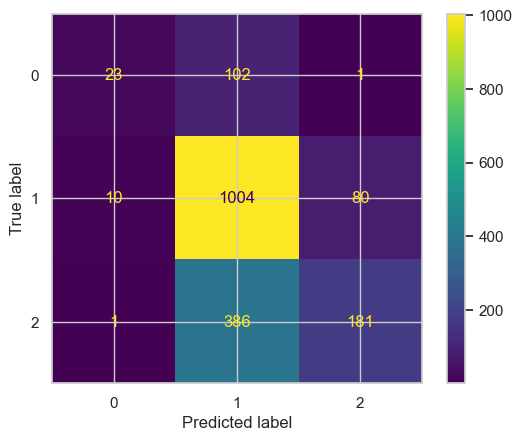

In [38]:


# Create a pipeline with TfidfVectorizer and SVM classifier with polynomial kernel
pipeline_base_svm = Pipeline([
    ('vect', TfidfVectorizer(max_features=2000, analyzer='word')),  # TfidfVectorizer for text feature extraction
    ('clf', svm.SVC(kernel='poly'))  # SVM classifier with polynomial kernel
])

# Fit the pipeline with training data
pipeline_base_svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svm = pipeline_base_svm.predict(X_test)

# Print the classification report to evaluate the model performance
print(classification_report(y_test, y_pred_svm))

# Plot the confusion matrix to visualize classification results
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_base_svm['clf'].classes_)  # Create ConfusionMatrixDisplay object
disp.plot()  # Plot the confusion matrix


### Grid Search

> Performing the Grid Search by defining a search space to test multiple combinations in order to find the best parameters for the model.

Best Parameters:  {'clf__C': 1, 'clf__kernel': 'rbf', 'vect__max_features': 3000}
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.13      0.22       126
           1       0.70      0.89      0.78      1094
           2       0.64      0.42      0.51       568

    accuracy                           0.69      1788
   macro avg       0.70      0.48      0.50      1788
weighted avg       0.68      0.69      0.65      1788

Confusion Matrix:


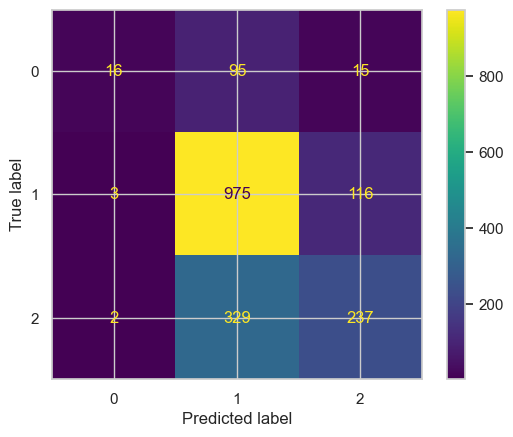

In [39]:
pipeline_base_svm = Pipeline([
    ('vect', TfidfVectorizer(analyzer='word')),
    ('clf', svm.SVC(kernel='poly'))])

# Define the parameter grid for the grid search
param_grid = {
    'vect__max_features': [1000, 2000, 3000],
    'clf__kernel': ['poly', 'rbf', 'sigmoid'],
    'clf__C': [0.1, 1, 10]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline_base_svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

# Print the best parameters
print("Best Parameters: ", best_params)

# Predict using the best estimator
y_pred_svm = best_estimator.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

# Plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator['clf'].classes_)
disp.plot()

**Model Training: Multinomial Naive Bayes Classifier with TfidfVectorizer**

In this section, I will evaluate the performance of a new model: the Multinomial Naive Bayes classifier. This analysis aims to compare its effectiveness with the previously tested SVM model.

              precision    recall  f1-score   support

           0       0.32      0.22      0.26       126
           1       0.73      0.71      0.72      1094
           2       0.50      0.56      0.53       568

    accuracy                           0.63      1788
   macro avg       0.52      0.50      0.50      1788
weighted avg       0.63      0.63      0.63      1788

Confusion Matrix:


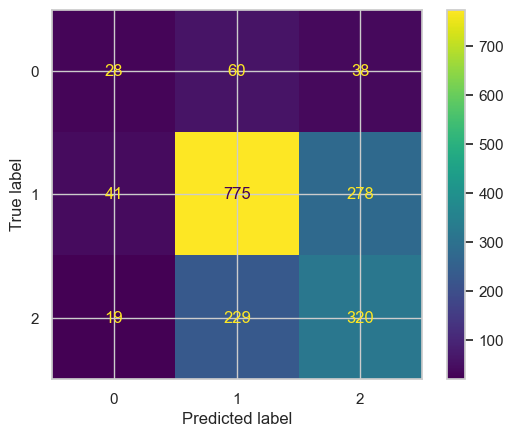

In [40]:
# Create a pipeline with CountVectorizer and Multinomial Naive Bayes classifier
pipeline_base_NB = Pipeline([
    ('vect', CountVectorizer(max_features=2000, analyzer='word')),  # CountVectorizer for text feature extraction
    ('clf', MultinomialNB())  # Multinomial Naive Bayes classifier
])

# Fit the pipeline with training data
pipeline_base_NB.fit(X_train, y_train)

# Make predictions on the test data
y_pred_NB = pipeline_base_NB.predict(X_test)

# Print the classification report to evaluate the model performance
print(classification_report(y_test, y_pred_NB))

# Plot the confusion matrix to visualize classification results
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_NB)  # Compute confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_base_NB['clf'].classes_)  # Create ConfusionMatrixDisplay object
disp.plot()  # Plot the confusion matrix


**GridSearch on Multinomial Naive Bayes**

I will also perform a grid search on this new model to assess whether we can achieve better performance.

Best Parameters:  {'clf__class_prior': [0.064, 0.603, 0.333], 'vect__max_features': 3000}
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.22      0.27       126
           1       0.72      0.72      0.72      1094
           2       0.51      0.55      0.53       568

    accuracy                           0.63      1788
   macro avg       0.52      0.50      0.51      1788
weighted avg       0.63      0.63      0.63      1788

Confusion Matrix:


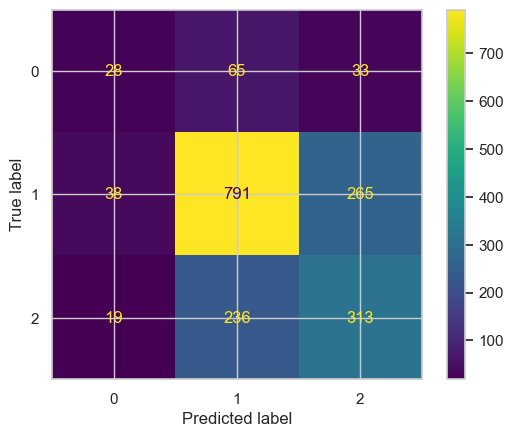

In [41]:
# Create a pipeline with CountVectorizer for text feature extraction and Multinomial Naive Bayes classifier
pipeline_base_NB =  Pipeline([
    ('vect', CountVectorizer(max_features=2500, analyzer='word')),  # CountVectorizer with specified parameters
    ('clf', MultinomialNB())  # Multinomial Naive Bayes classifier
])

# Define the parameter grid for the grid search
param_grid = {
    'vect__max_features': [1000, 2000, 3000],  # Test different max_features values for CountVectorizer
    'clf__class_prior': [[0.064, 0.603,0.333], [0.55,0.15,0.3], [0.45, 0.25, 0.3]],  # Test different class_prior values for Multinomial Naive Bayes
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline_base_NB, param_grid, cv=5)  # GridSearchCV with specified pipeline and parameter grid
grid_search.fit(X_train, y_train)  # Fit the grid search with training data

# Get the best parameters and best estimator from grid search
best_params = grid_search.best_params_  # Best parameters found during grid search
best_estimator = grid_search.best_estimator_  # Best estimator (pipeline) found during grid search

# Print the best parameters
print("Best Parameters: ", best_params)

# Predict using the best estimator
y_pred_NB = best_estimator.predict(X_test)  # Make predictions on the test data using the best estimator

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_NB))  # Print the classification report for the predictions

# Plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_NB)  # Compute confusion matrix for the predictions
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_estimator['clf'].classes_)  # Create ConfusionMatrixDisplay object
disp.plot()  # Plot the confusion matrix

In [42]:
from collections import Counter
word_count = Counter(' '.join(X_train).split())
word_counts = dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

# Sort the words by frequency in descending order
sorted_words = sorted(word_counts.keys(), key=lambda word: word_counts[word], reverse=True)
# Create a vocabulary dictionary with word indexes
vocabulary = {word: index for index, word in enumerate(sorted_words)}

In [43]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-twitter-25")

In [44]:
loaded_glove_embeddings = loaded_glove_model.vectors

def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    embeddings = glove_model.vectors
    return voc, embeddings

loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

In [45]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocabulary)

In [46]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    num_sentences = len(texts)
    embedding_size = embeddings.shape[1]
    sentence_reprs = np.zeros((num_sentences, embedding_size))

    for i, text in enumerate(texts):
        words = text.split()
        word_indices = [vocabulary[word] for word in words if word in vocabulary]
        if len(word_indices) > 0:
            word_embeddings = embeddings[word_indices]
            sentence_reprs[i] = np_func(word_embeddings, axis=0)

    return sentence_reprs

In [47]:
from sklearn.linear_model import LogisticRegression

# Exemple with embeddings from Glove
rep = sentence_representations(list(X_train), vocabulary, GloveEmbeddings)
clf = svm.SVC(kernel='rbf').fit(rep, y_train)
rep_test = sentence_representations(list(X_test), vocabulary, GloveEmbeddings)
y_pred_emb = clf.predict(rep_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       126
           1       0.64      0.96      0.77      1094
           2       0.59      0.14      0.23       568

    accuracy                           0.63      1788
   macro avg       0.41      0.37      0.33      1788
weighted avg       0.58      0.63      0.54      1788

Confusion Matrix:


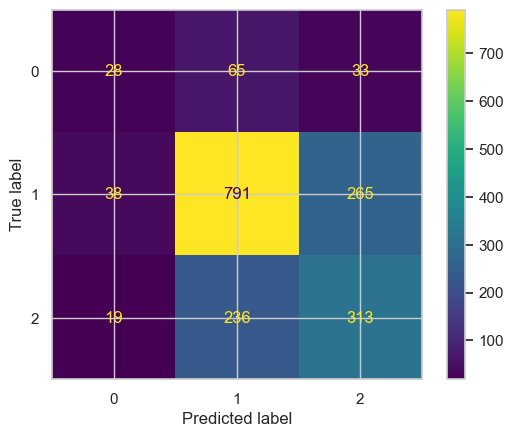

In [48]:
# Call the classification_report function with the labels
print(classification_report(y_test, y_pred_emb))
cm = confusion_matrix(y_test, y_pred_emb)

#Plot confusin matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_NB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = clf.classes_)
disp.plot()

In [49]:
import pandas as pd
from sklearn.utils import resample

class_counts = tweets_df['emotions'].value_counts()

# Find the size of the minority class (the class with the fewest samples)
minority_size = class_counts.min()

# Create DataFrames for each class and initialize a new dataframe
class_dfs = [tweets_df[tweets_df['emotions'] == emotion] for emotion in tweets_df['emotions'].unique()]
balanced_df = pd.DataFrame()

# Randomly undersample the majority classes to match the size of the minority class
for class_df in class_dfs:
    if len(class_df) > minority_size:
        undersampled_class_df = resample(class_df, replace=False, n_samples=minority_size, random_state=42)
        balanced_df = pd.concat([balanced_df, undersampled_class_df])
    else:
        balanced_df = pd.concat([balanced_df, class_df])

In [50]:
X_balanced = balanced_df['tweets_processed']
y_balanced = balanced_df.emotions

X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42) 

              precision    recall  f1-score   support

           0       0.54      0.52      0.53       121
           1       0.42      0.34      0.38       109
           2       0.49      0.60      0.54       112

    accuracy                           0.49       342
   macro avg       0.48      0.49      0.48       342
weighted avg       0.49      0.49      0.48       342

Confusion Matrix:


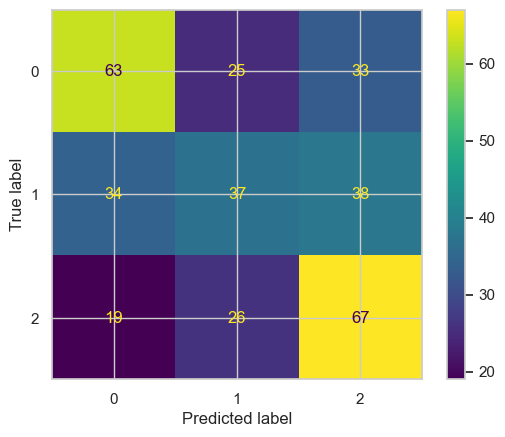

In [51]:
from sklearn.pipeline import Pipeline

pipeline_base_svm = Pipeline([
    ('vect', TfidfVectorizer(max_features=2000)),
    ('clf', MultinomialNB())])
pipeline_base_svm.fit(X_train_balanced, y_train_balanced)
y_pred_svm = pipeline_base_svm.predict(X_test_balanced)
print(classification_report(y_test_balanced, y_pred_svm))

#Plot confusin matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test_balanced, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_base_svm['clf'].classes_)
disp.plot()

#### XgBoost

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline_base_XgBoost = Pipeline([
    ('vect', CountVectorizer(max_features=1500, analyzer='word')),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.8, max_depth=1, random_state=0))
])
pipeline_base_XgBoost.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(max_features=1500)),
                ('clf',
                 GradientBoostingClassifier(learning_rate=0.8, max_depth=1,
                                            random_state=0))])

#### For train set

              precision    recall  f1-score   support

           0       0.62      0.25      0.35       444
           1       0.71      0.92      0.80      4294
           2       0.76      0.43      0.55      2410

    accuracy                           0.72      7148
   macro avg       0.70      0.53      0.57      7148
weighted avg       0.72      0.72      0.69      7148

Confusion Matrix:


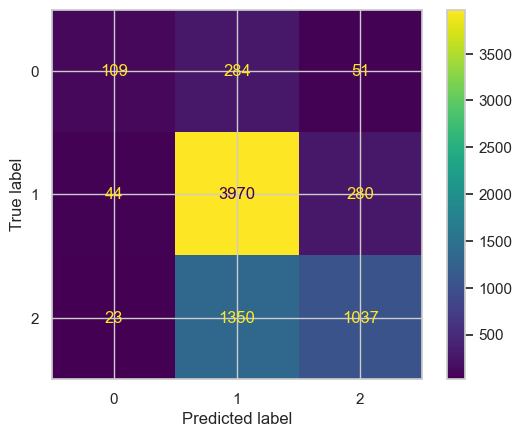

In [53]:
##for train set
y_train_pred_XgBoost = pipeline_base_XgBoost.predict(X_train)
print(classification_report(y_train, y_train_pred_XgBoost))
#Plot confusin matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_train, y_train_pred_XgBoost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_base_XgBoost['clf'].classes_)
disp.plot()

#### For test set

              precision    recall  f1-score   support

           0       0.43      0.10      0.17       126
           1       0.69      0.90      0.78      1094
           2       0.62      0.36      0.45       568

    accuracy                           0.67      1788
   macro avg       0.58      0.45      0.47      1788
weighted avg       0.65      0.67      0.63      1788

Confusion Matrix:


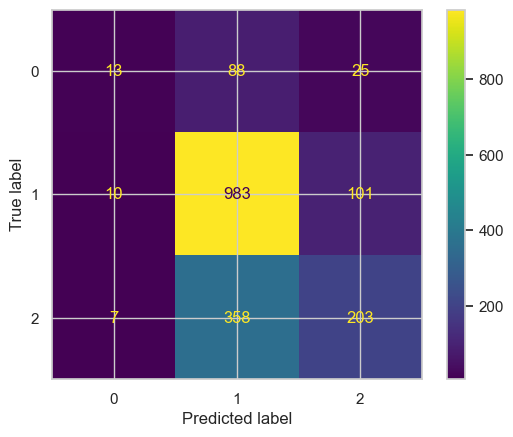

In [54]:
## For test set
y_pred_XgBoost = pipeline_base_XgBoost.predict(X_test)
print(classification_report(y_test, y_pred_XgBoost))
#Plot confusin matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_XgBoost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_base_XgBoost['clf'].classes_)
disp.plot()

The two plots above show the confusion matrix and classification reports given by XgBoost for both train and test sets respectively, we can assume from its results that the model doesn't overfit since the train accuracy and test accuracy aren't too different 

In [55]:
from sklearn.model_selection import cross_val_score

pipeline_base_XgBoost = Pipeline([
    ('vect', CountVectorizer(max_features=1500, analyzer='word')),
    ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=0.8, max_depth=1, random_state=0))
])

# Perform cross-validation
cv_scores = cross_val_score(pipeline_base_XgBoost, X_train, y_train, cv=5)

In [56]:
cv_scores

array([0.65944056, 0.66503497, 0.68041958, 0.66410077, 0.66620014])